# Twitch Streamer Partnership 
***
by Griffin Hundley

![](../images/twitch-generic-email-1-1-1-1.jpg)

## Overview

Twitch is a social platform for livestreaming video games, music, art, and more.  For most people making content on the platform, livestreaming started out as a hobby for people sharing their love of gaming - something they do only because its fun.  For a select few who build a strong community and gain a larger audience, they can turn their channel into a primary source of income by becoming a partner with Twitch.

Being a partner has a lot of perks, but also a few restrictions.  Partners get a subscription button added to their channel, where viewers can pay $5 for 1 month access to subscriber-only emotes, don't have to watch advertisements, and receive channel specific rewards.  Partners also get a share of the revenue for ads ran on their channel.  As part of the contract that partners sign, they cannot livestream on other platforms.

As of February 2020, there are 3.8 million unique broadcasters on the website, with an average of 56,000 concurrent broadcasters, and 1.44 million concurrent viewers at a given time.  Of those 3.8 million broadcasters, there are roughly 41,000 partners. 

Source: Mansoor Iqbal https://www.businessofapps.com/data/twitch-statistics/

***

## Business Problem

![](../images/twitch-average-monthly-broadcasters.png)

Source: Mansoor Iqbal https://www.businessofapps.com/data/twitch-statistics/

Livestreaming is emerging as a premiere online industry, with significant growth over the years.  As of December 2020, the effects of COVID are still being realized, however there are reports of 24-50% increase in Twitch viewership as a result of the pandemic lockdowns (T. Wilde).

Online entertainment isn't going anywhere.  As a result of increasing scale, more online companies must rely on automated systems.  For example - Twitch competitors Youtube Live and Facebook Gaming use automated systems to detect copywrite infringment and obscene content.  As the number of broadcasters and viewers continues to rise, and as the entertainment industry shifts more online, the number of people turning to livestreaming as a source of income increases.  

Applications for partnership are currently reviewed manually by Twitch staff, with applicants waiting 2-4 weeks to get results (Twitch FAQ).  Because partnership is approved manually by different individuals, there can be a personal selective bias towards or against certain demographics.  In some cases, very successful streamers with well above average metrics have been denied partnership, while much smaller channels are approved, leading to distrust between the broadcaster and Twitch.  

The goal of this analysis is to provide a model that can approve or deny channels for partnership based on their channel metrics, removing the need for manual review, which frees up resources, decreases feedback time to streamers on the status of their partnership application, and having a system without personal bias.  Additionally, the nature of the model allows for dynamically adjusting the threshold for approval, to make it more or less strict depending on the needs of Twitch.

Source: Thomas Wilde https://www.geekwire.com/2020/twitch-sets-audience-record-october-pandemic-continues-fuel-livestreaming-growth/

***

## Data

Over the course of a week, at different times during the day, the Twitch API was queried through all of the pages of currently live broadcasters to generate a list of \~800,000 broadcasters.  These broadcasters were then filtered to only channels older than 60 days, with over 900 viewers (\~300,000 broadcasters).  This is to filter out brand new channels, and only to examine channels that meet the basic number of viewers to be considered for partnership as described in the Path to Partnership achievement. From the twitch api, the data being collected covers:

```view_count```: total number of lifetime channel views

```account_age```: time since account creation

```broadcaster_type```: (partner, affiliate, unaffiliated)

From these \~300K broadcasters, a random sample of 10% of those channels (\~30k) was chosen to obtain a reasonably sized dataset.  For these \~30k channels, data was webscraped from twitchtracker.com.  The channel metrics being examined are lifetime aggregate channel data.  The specific metrics gathered are:

```hours_streamed```: total number of hours stream has been live

```average_viewers```: average number of concurrent viewers

```peak_viewers```: peak number of concurrent viewers

```days_of_activity```: total number of days where stream was live

```total_games_streamed```: total number of games streamed

```daily_broadcast_time```:  average hours channel is live per day

```hours_watched_daily```: average number of hours watched by viewers per day

```followers_per_stream```: average number of followers gained per stream

```views_per_stream```: average number of concurrent viewers per stream

```followers_per_hour```: average number of followers per hour

```views_per_hour```: average number of views per hour

```hours_watched```: total hours watched by viewers

```active_days_per_week```: average of how many days per week the broadcast is live

```average_games```:  average number of games played per stream

***

### Data Assumptions

A key assumption being made with this analysis is that a channel's total lifetime aggregate metrics can be used to classify a channel by partnership.  Not having access to the date when a channel is partnered, analysis can only be made on the metrics as they currently are, not when the channel was partnered.  As a result, theoretically this biased analysis should produce a harsher classifier, with the idea that once a channel is partnered it will continue to grow and inflate its metrics, and by association inflate the decision boundary.  If a model produced from this analysis were to be used by Twitch in its partnership approval process, in deployment, Twitch would have access to those specific metrics and would not have this bias.

Another assumption this analysis makes is that the distribution of streamers who were recently-live over the late fall data collection period is representitive of all streamers as a whole.  As only streamers who were recently live over the data collection period were included in the analysis, only ~5% of the total number of partners were counted.  As such, any seasonality that exists among streamers, for example - summertime streamers that have access to a larger audience of individuals on summer break - would not be captured.

Features not used in this analysis that Twitch currently uses in their partner selection is chat interaction - how active are the viewers in the chat room.  This information would theoretically be important to classifying small streams, as a small stream with a very active chat could be partners.

Additionally, Twitch makes a distinction between 'natural' views and views gained through hosts and raids (when one channel sends all of its viewers to another channel), and only natural views count towards their decision.  This analysis has no method of identifying natural views from views gained through hosts or raids, and will assume that views are natural.  The theoretical effect of this assumption is a slight deflation of importance in view-related features.

Finally, the unpartnered class is assumed to be vying for partnership.  Twitch records of which channels have been previously denied for partnership, along with the dates and frequency of their denial, are not accessible. These would be important features to include in a final implementation of the resulting model, as a distinction could be made between streamers who are just casually streaming, and those seriously considering partnership.
***

## Exploratory Data Analysis

In [1]:
import sys
sys.path.append('../')
from src import eda
%load_ext autoreload
%autoreload 2

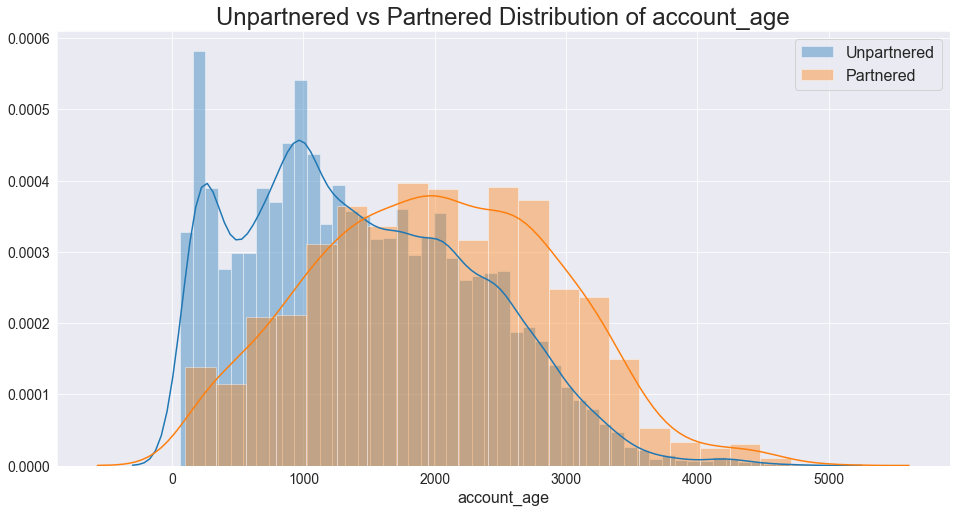

In [25]:
# plot the distribution of the account_age column by class
fig = eda.hist_plot('account_age')
# fig.savefig('../images/account_age_distplot.png',
#             bbox_inches='tight')

The figure above shows the frequency distribution of account ages of Twitch streamers.  In blue is unpartnered accounts, and orange is partnered accounts.  The account ages range from 60 days old to ~5000 days old.  On average, unpartnered accounts are slightly younger than partnered accounts. 

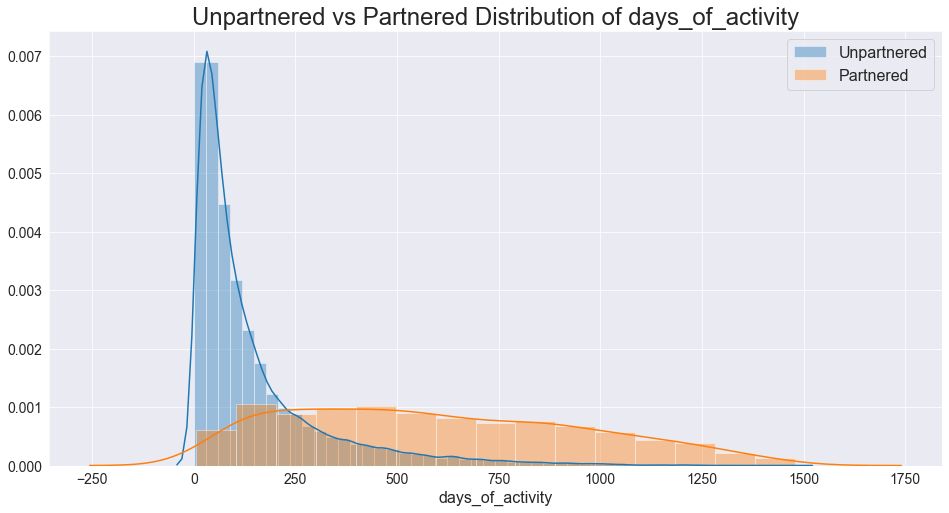

In [26]:
# plot the distribution of the days_of_activity column by class
fig = eda.hist_plot('days_of_activity');
# fig.savefig('../images/days_of_activity_distplot.png',
#             bbox_inches='tight')

In the figure above is the distribution of streamers days of activity (the number of total days during which that streamer went live).  The range is 0 to ~1500 days. In blue is unpartnered accounts, and in orange is partnered accounts. The peak for unpartnered accounts is much lower and sharper, meaning many more unpartnered streamers are less active compared to the partnered streamers, who stream more consistently over a longer period of time.

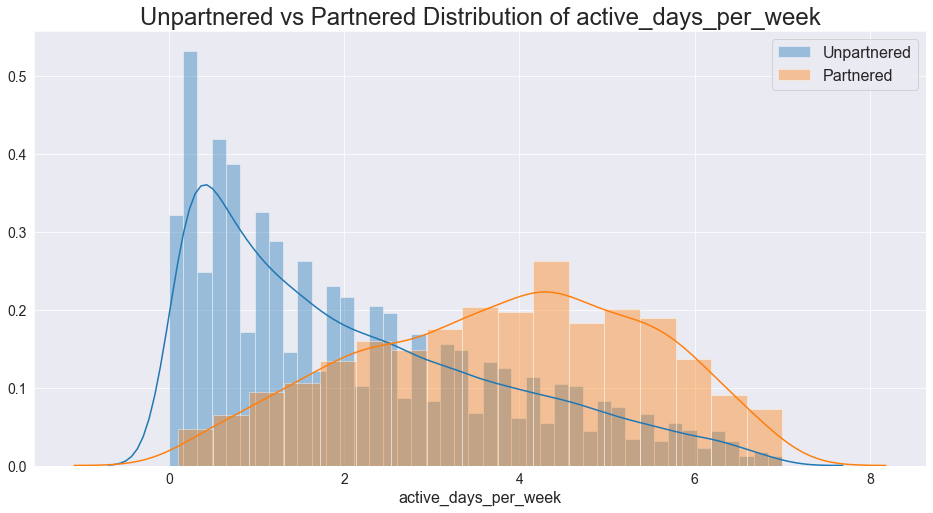

In [27]:
# plot the distribution of the days_of_activity column by class
fig = eda.hist_plot('active_days_per_week');
# fig.savefig('../images/active_days_per_week_distplot.png',
#             bbox_inches='tight')

The figure above shows the distribution of active days per week (the average number of days in a 7 day period where a streamer goes live).  In the blue, we see that the unpartnered streamer class exhibits a right tailed distribution that peaks closer to 1 day per week, while the partnered streamer class exhibits a left tailed distribution, peaking around 4 days per week.

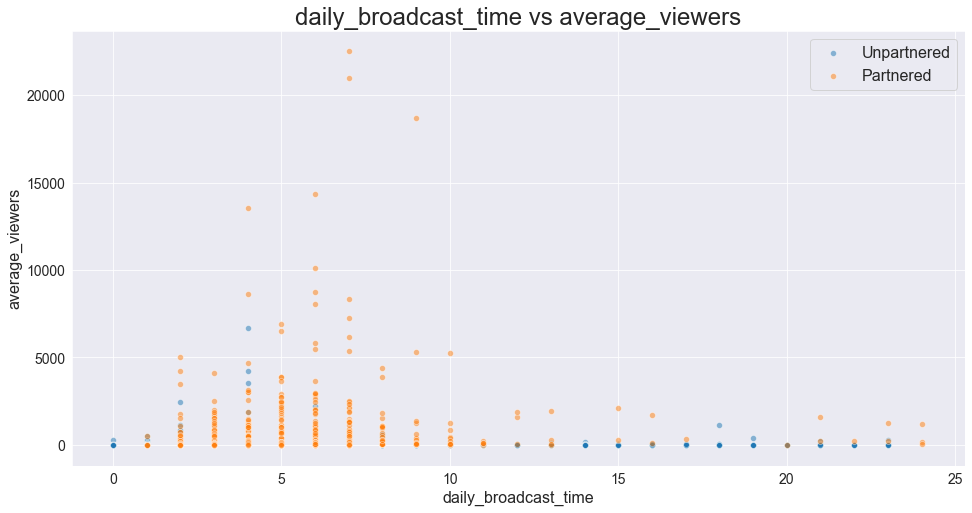

In [28]:
fig = eda.scatter_fig('daily_broadcast_time', 'average_viewers');
# fig.savefig('../images/daily_broadcast_time_vs_average_viewers_scatterplot.png',
#             bbox_inches='tight')

The figure above is a scatter plot showing the average viewers for average daily broadcast time.  The highest average viewer counts exist for streamers that average around 4-7 hours of broadcast time per day.  Additionally, the highest viewer counts appear to be held by partnered streams.

## Model and Evaluation

The final model used in this analysis, details found in the [modeling notebook](modeling.ipynb), is a neural net binary classifier with the following architecture:

1 Input layer (18x1) -> 

4 node Dense Layer with 20% Dropout and Relu activation ->  

8 node Dense Layer with 20% Dropout and Relu activation ->

1 Output layer with sigmoid activation

The model was optimized with adaptive moment estimation, used binary crossentropy as the loss function, and the data was fit over 100 epochs with minibatches of size 32.

The primary metrics for evaluation will be precison and sensitivity, with the objective of reducing the number of false positives.  A highly selective model will be able to confidently distinguish the negative class.  Other diagnostic metrics used in the modeling process will be f1, accuracy, recall, and total loss, with the goal of selecting a generalizable model that  maintains its ability to distinguish the positive class as well.

In [29]:
# import the model from the models directory
from keras.models import load_model
model = load_model('../models/model_4.h5')

In [30]:
# imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# load in the data
df = pd.read_csv('../data/streamer_data.csv')
# drop unnecessary columns
df = df.drop(columns = ['game_name', 'login', 'broadcaster_type', 'language'])
# change dtype from string to timedelta
df.account_age = pd.to_timedelta(df.account_age).map(lambda x: x.days)
# store the labels for each feature
labels = df.columns
# split the target (partnership status) from the features into separate dataframes
X = df.drop(columns = 'target')
# data is scaled with standardscaler to prevent exploding/vanishing terms
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = df.target
# split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Model 4 Performance and Validation

![](../images/model_4_performance.png)

In the figures above, showing the training and validation loss, accuracy, and precision metrics over the epochs of training for the final model, this model performed the best of all the iterations. The reduction in complexity, as well as the dropout regularization, has the model consistently perform better on the validation set than on the training set indicating high generalizability. Additionally, the extreme amounts of fluctuations over epochs seems to have been smoothed out considerably compared to the earlier iterations.

In [31]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])

Test loss: 0.05081172659993172
Test accuracy: 0.9803656339645386
Test precision: 0.8715953230857849
Test recall: 0.7296416759490967


![](../images/model_4_threshold_comparison.png)

Visually examining the scores by threshold shows a triple point at around 0.37, where the recall, precision, and f1 converge.  Also, the f1 score shows a plateau that extends beyond 0.37 until around 0.74, where the f1/recall score sharply drops off. At that 0.74 threshhold the model achieves a precision of ~0.95 without taking a significant loss to the f1/recall.  For this model, a threshold of 0.37 - 0.74 would be viable.  

In [32]:
# calculating the metrics for the threshold of 0.74
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
threshold = 0.74
y_preds = model.predict(X_test)
y_preds_thresh = [1 if x > threshold else 0 for x in y_preds]
f1 = f1_score(y_test, y_preds_thresh)
prec = precision_score(y_test, y_preds_thresh)
recall = recall_score(y_test, y_preds_thresh)
print('Test F1:', f1)
print('Test precision:', prec)
print('Test recall:', recall)

Test F1: 0.7370517928286853
Test precision: 0.9487179487179487
Test recall: 0.6026058631921825


In [33]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_thresh).ravel()
specificity = tn / (tn + fp)
print(specificity)

0.9982146045349045


Using a confusion matrix on the test set to calculate the specificity gives a result of 99%.  With a precision of 95%, this model succeeds in being very selective against non-partners.  

### Holdout Data Test

After confirming the model with tests on the validation set, an independently collected holdout set was obtained.  This dataset was collected with the same criteria as the training set, but after the model selection process to avoid data leakage.

In [34]:
# load final model
model = load_model('../models/model_4.h5')
# load pickled scaler
from pickle import load
scaler = load(open('../data/scaler.pkl', 'rb'))

In [35]:
# load the holdout data and transform with StandardScaler imported from training set.
df_2 = pd.read_csv('../data/streamer_data_2.csv')
df_2 = df_2.drop(columns = ['game_name', 'login', 'broadcaster_type', 'language'])
df_2.account_age = pd.to_timedelta(df_2.account_age).map(lambda x: x.days)
# separate the features from the target
X_test = df_2.drop(columns = 'target')
y_test = df_2.target
# scale the features for the model
X_test = scaler.transform(X_test)

In [36]:
# set the threshold
threshold = 0.74
# generate prediction probabilities
y_preds = model.predict(X_test)
# classify predictions based on threshold
y_preds_thresh = [1 if x > threshold else 0 for x in y_preds]
# calculate scores
f1 = f1_score(y_test, y_preds_thresh)
prec = precision_score(y_test, y_preds_thresh)
recall = recall_score(y_test, y_preds_thresh)
print('Test F1:', f1)
print('Test precision:', prec)
print('Test recall:', recall)

Test F1: 0.7030878859857482
Test precision: 0.921161825726141
Test recall: 0.5685019206145967


In [37]:
# create confusion matrix from predictions
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_thresh).ravel()
tn, fp, fn, tp

(16573, 38, 337, 444)

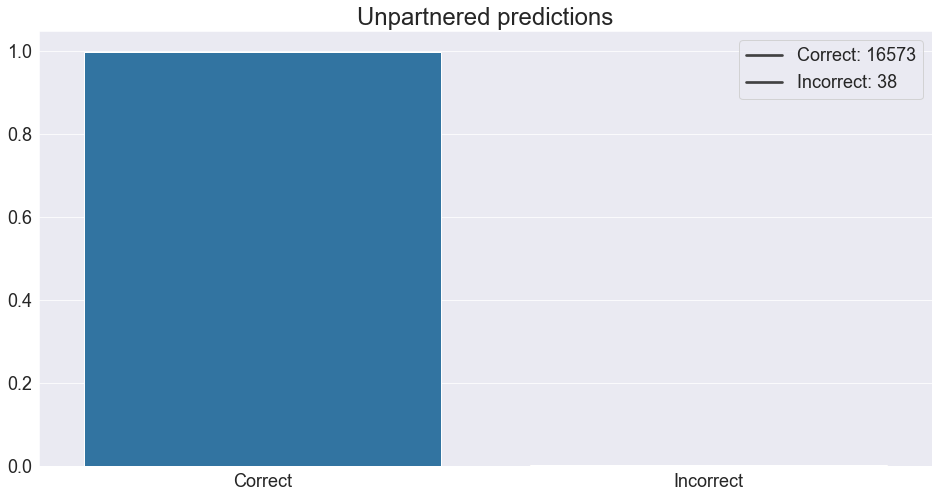

In [68]:
# visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize = (16,8))
ax.set_title('Unpartnered predictions', fontsize = 24)
ax.tick_params(labelsize = 18)
sns.barplot(x = ['Correct', 'Incorrect'],
            y = [tn/(tn+fp),fp/(tn+fp)])
ax.legend([f'Correct: {tn}', f'Incorrect: {fp}'], fontsize = 18);
# fig.savefig('../images/negative_class.png',
#             bbox_inches='tight')

Visualizing how the model performs at selecting the negative class, it apparently performs very well.  Out of `16,611` truly unpartnered channels, the model correctly classifies `16,573` of them, and incorrectly classifies `38`.

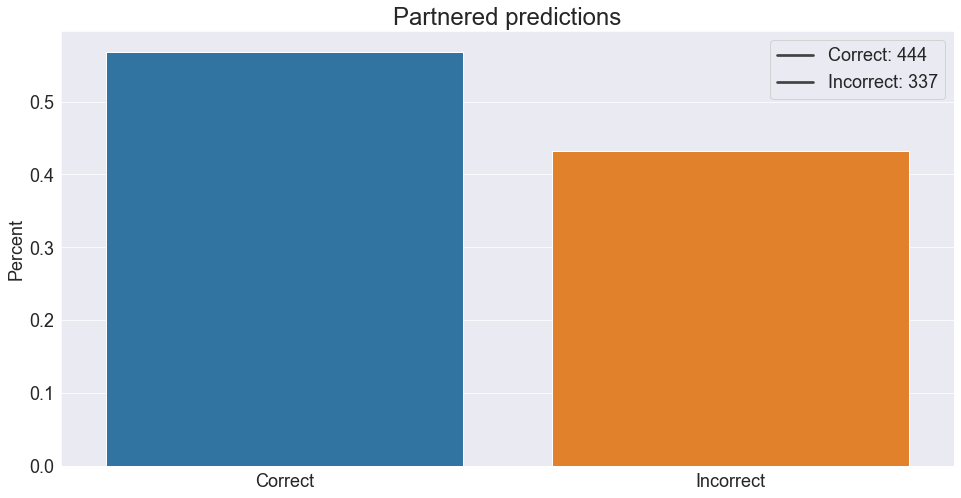

In [69]:
fig, ax = plt.subplots(figsize = (16,8))
ax.set_title('Partnered predictions', fontsize = 24)
ax.tick_params(labelsize = 18)
ax.set_ylabel('Percent', fontsize = 18)
sns.barplot(x = ['Correct', 'Incorrect'],
            y = [tp/(tp+fn),fn/(tp+fn)])
ax.legend([f'Correct: {tp}', f'Incorrect: {fn}'], fontsize = 18);
# fig.savefig('../images/positive_class.png',
#             bbox_inches='tight')

From this confusion matrix, out of `16,611` truly non-partnered channels, only `38` were falsely classified as being partner, indicating a specificity of `0.998`. Regarding the true partner class, of `781`, `444` were correctly classified as partner, giving a recall/sensitivity of `0.57`. This corresponds with the initial assumption that the nature of the model would be more selective due to the inherent bias in the data.
***

## Conclusion

This model performs very well at being selective with a specificity of 0.998 and a precision of .92.  Although it suffers a bit with a 57% hit rate on partnered channels, because denied applications can reapply at a later point, it's not a permanent decision, where in the reverse case, giving a stream partnership is usually permanent.  When a channel is denied, they have an unlimited number of attempts, giving them time to build their channel and reapply later with a better chance of success.

One serious flaw however, is this model fails to account for chat participation and interaction, and does not assess individual character/behavior to identify if a streamer is a brand risk or poor representitive of the company.  A widely popular streamer who constantly brings negative attention to the platform, for example, might not be a wise choice to partner.  To address this concern, this model could be used in conjunction with another classifier model that specifically looks at chat interaction, with the purpose of detecting negativity and brand risk with natural language processing.

Twitch currently approves ~5k partners per year.  With the number of streamers doubling every few years, and with previously denied applicants constantly resubmitting applications, the number of applications will continue to increase, causing the current method of manual selection to need adjustment.  Given this, I recommend this model be used as a transitionary adjunct to the current system to increase it's capacity and reduce feedback delay.  

In this case, the model will generate probabilities for channels, with a threshold below which channels are denied, and channels above which are reviewed by hand, taking into account the chat interaction and identify if they are a good representitive of the company.  This would reduce the amount of applications needed to be looked at manually, and the assigned probability can assist the staffperson in their review.

With the models 99.8% specificity, this model will correctly discriminate the vast majority of unpartnered channels.  As these will be the majority of applications, the model succeeds in its goal to reduce the amount of manual review.  For the channels where the probability is high, manual review will still be necessary.

In this transitionary period, the effects of the model could be field tested.  Feedback from this field test would be implemented into a full switch from manual review to a fully machine based application process that considering channel metrics, chat interaction, brand risk, etc.  This addresses the scalability of the application process, and will potentially reduce or eliminate personal bias introduced by multiple individual staff members being involved in the process.
***

## Next Steps

Moving forward I would like to address the assumptions made with the data.  With access to Twitch's data that excludes artifical views, and can target historical data at the time of partnership, the model would likely be much more accurate at predicting the partner class without losing it's selectivity against unpartnered channels.

Additionally, expanding the amount of data collection is a logical next step.  In this analysis only 5% of the total partners were included in the dataset.  A more representitive model would be a random subset of the entire partner population.

Twitch currently uses chat activity as an important metric when deciding partnership.  Getting data on chat participation, and chat activity, in addition to identifying negativity and sentiment would address the flaws in the current model.
***